## Claustrophobic Streets
Work by Matt Franchi


### Notebook Description: 
In this notebook, we segmentize the official NYC sidewalk shapefile into individual points, at a threshold of 50 feet. This allows us to approximate street metrics with more granularity than otherwise, where sidewalks are grouped together by street segment. 

### Performance Notes: 
We run this notebook on a compute node with 64GB RAM and 8 CPUs. 




In [27]:
import geopandas as gpd 
import matplotlib.pyplot as plt 

# use latex plotting 
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
# plot a zoom in of a neighborhood 
# load nyc ntas 
nyc_ntas = gpd.read_file("../data/nynta2020_24b/nynta2020.shp")
nyc_ntas.crs = "EPSG:2263"
NOI = 'Greenpoint'

In [4]:
nyc_streets = gpd.read_file('../data/Sidewalk.geojson').to_crs("EPSG:2263")

In [5]:
# crop nyc_streets to the neighborhood of interest
nyc_streets_crop = gpd.sjoin(nyc_streets, nyc_ntas[nyc_ntas.NTAName == NOI], op='within')

/share/ju/conda_virtualenvs/urbanekg/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [6]:
# simplify the cropped geometry 
nyc_streets_crop_simplified = nyc_streets_crop.simplify(10)

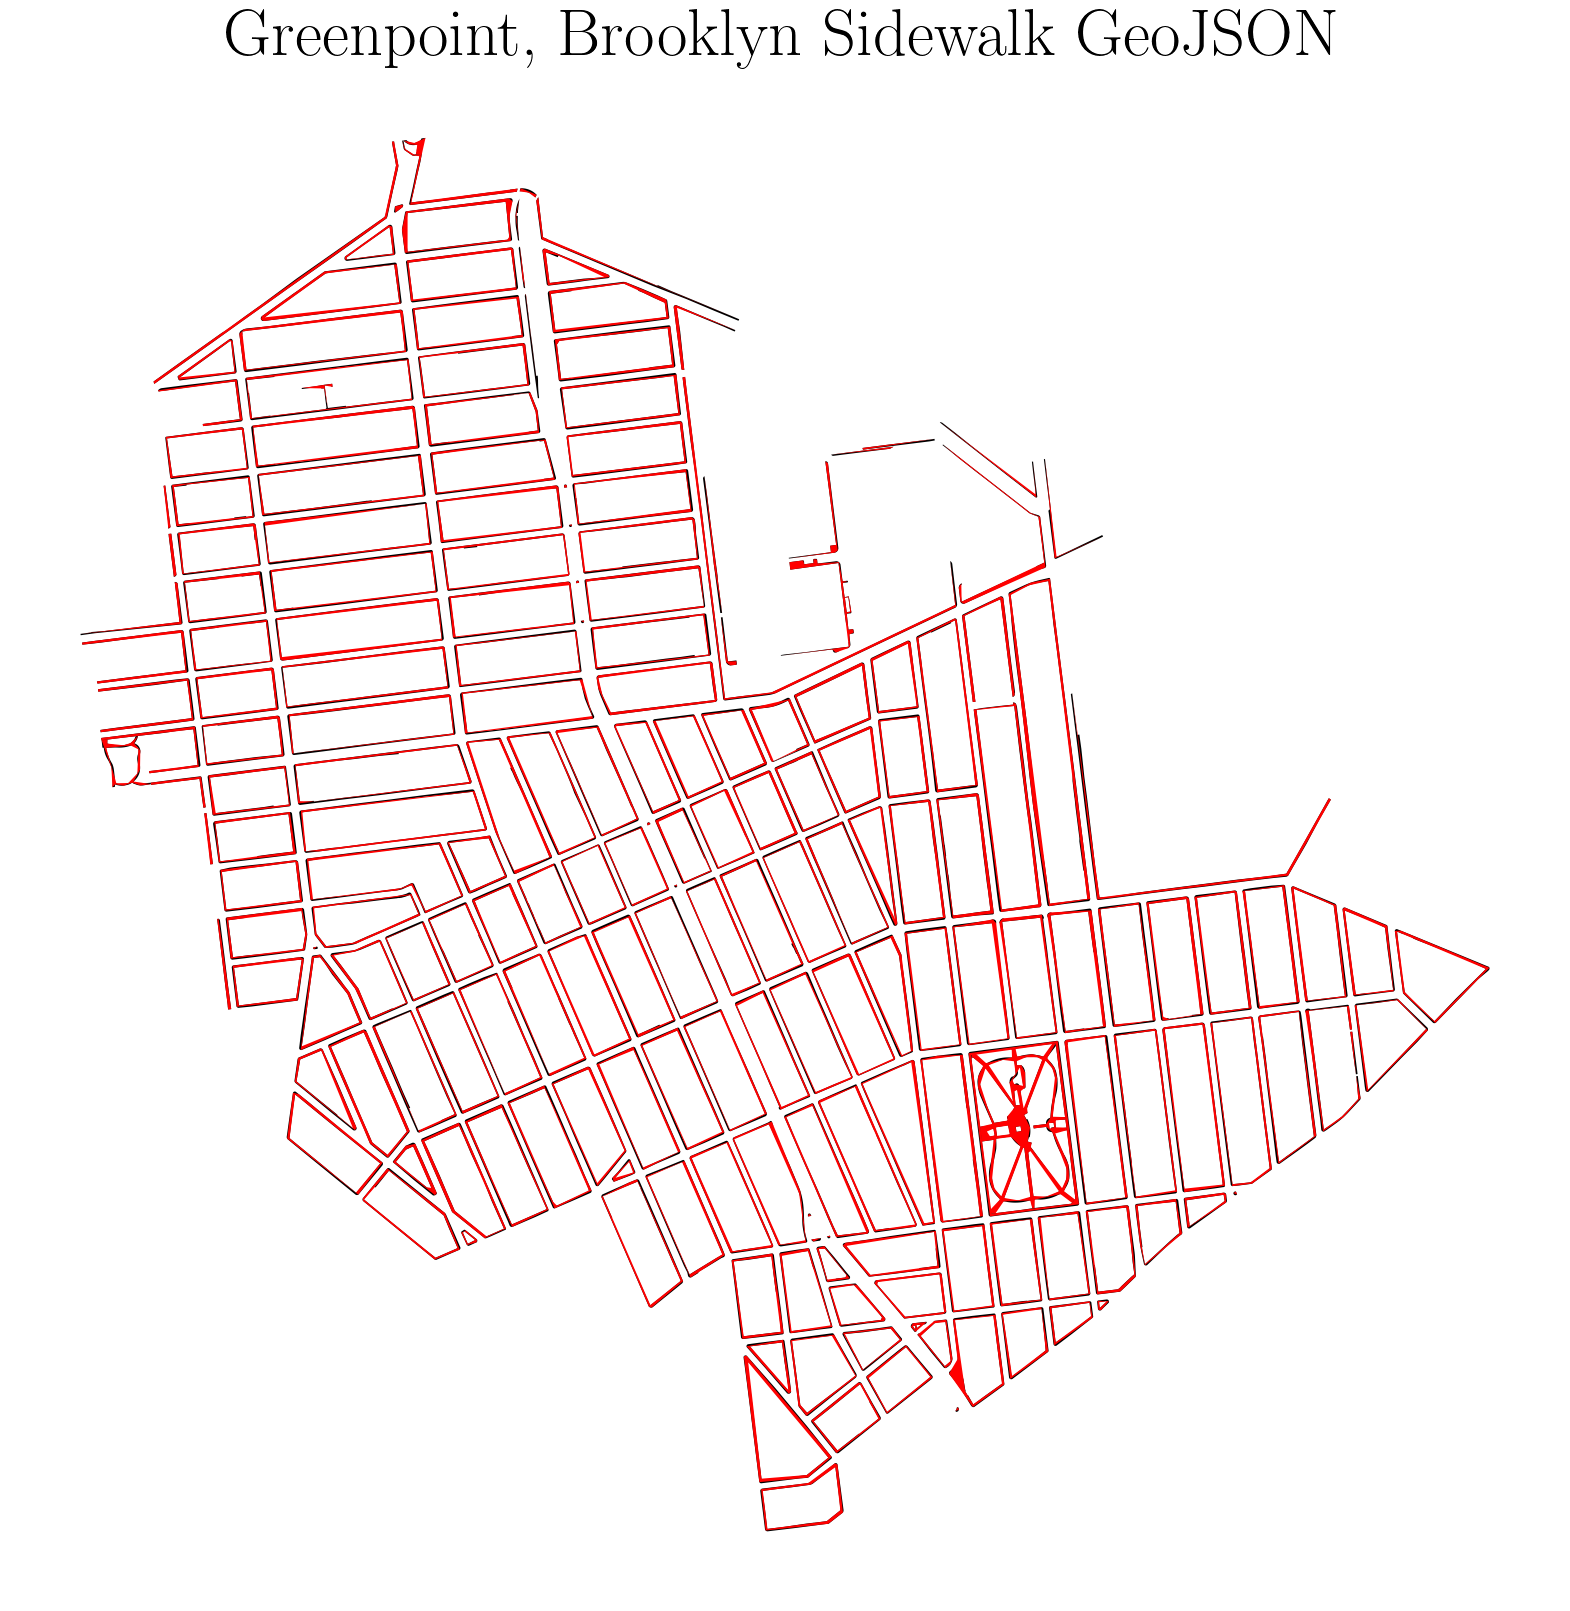

In [39]:
fig, ax = plt.subplots(figsize=(20,20))

nyc_streets_crop.plot(ax=ax, color='black', linewidth=0.5)
nyc_streets_crop_simplified.plot(ax=ax, color='red', linewidth=0.5)

ax.set_axis_off() 

ax.set_title("Greenpoint, Brooklyn Sidewalk GeoJSON", fontsize=48)

plt.savefig("../figures/greenpoint_sidewalks.png", dpi=300, bbox_inches='tight')


In [8]:
# AT THIS POINT, assume simplification is satisfactory 
# apply to nyc_streets 
nyc_streets['geometry'] = nyc_streets.simplify(10)

In [9]:
segmentized = nyc_streets.segmentize(50).extract_unique_points().explode(index_parts=True)

In [10]:
# merge rest of data with segmentized 
segmentized = gpd.GeoDataFrame(segmentized).reset_index()

In [11]:
segmentized.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2532597 entries, 0 to 2532596
Data columns (total 3 columns):
 #   Column   Dtype   
---  ------   -----   
 0   level_0  int64   
 1   level_1  int64   
 2   0        geometry
dtypes: geometry(1), int64(2)
memory usage: 58.0 MB


In [12]:
segmentized = segmentized.merge(nyc_streets,left_on='level_0',right_index=True).drop(columns=['level_0','level_1','geometry'])
segmentized['geometry'] = segmentized.iloc[:,0]
segmentized.drop(segmentized.columns[0],axis=1, inplace=True)

In [13]:
segmentized = gpd.GeoDataFrame(segmentized).to_crs('EPSG:2263')

In [14]:
# crop segmentized to 'Greenpoint' NTA 
nta_crop = nyc_ntas[nyc_ntas['NTAName']==NOI]
segmentized_crop = gpd.clip(segmentized,nta_crop)

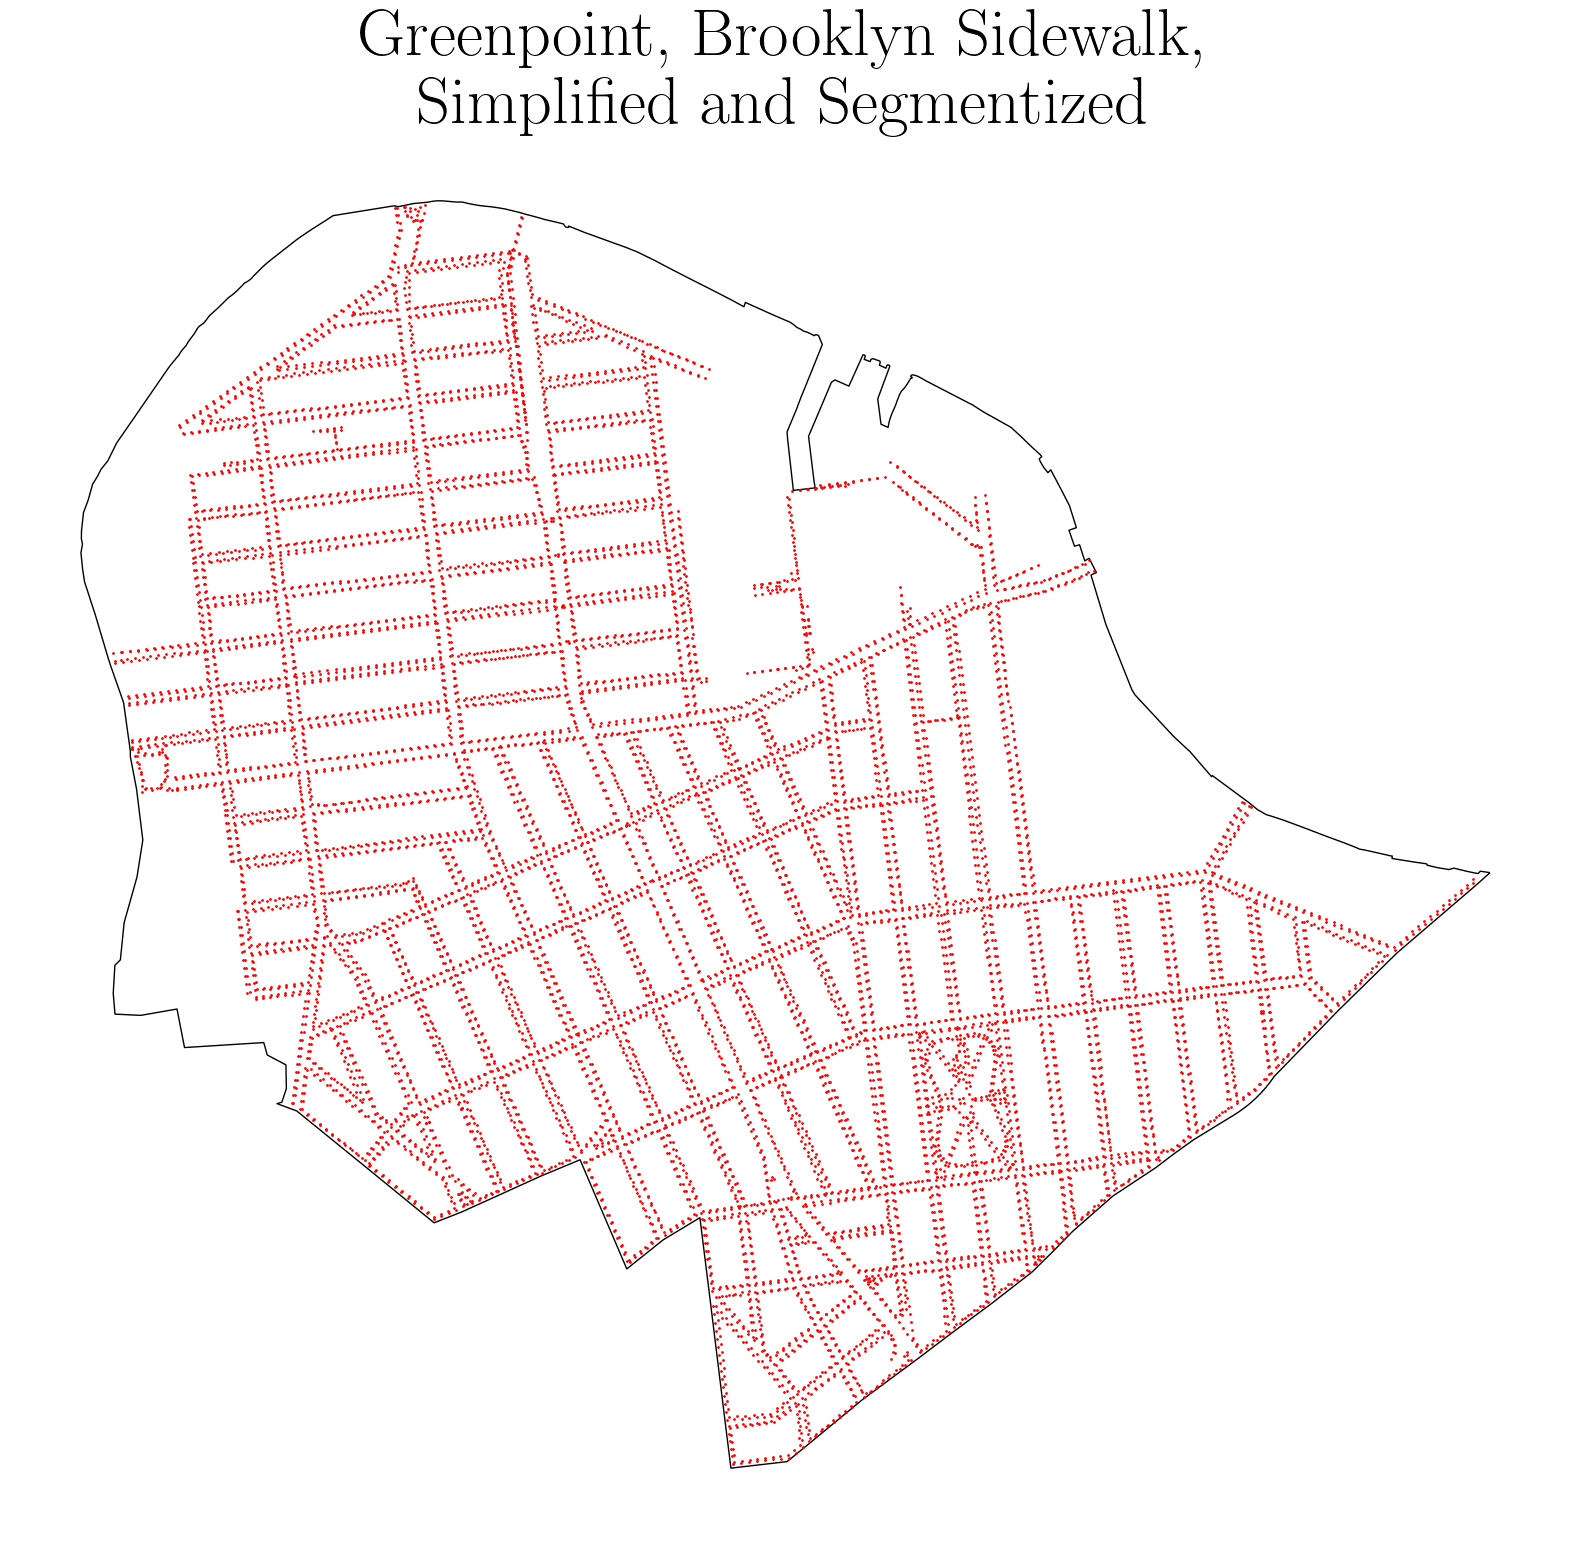

In [38]:
# visualize the crop 
fig, ax = plt.subplots(figsize=(20,20))

nta_crop.plot(ax=ax, color='white', edgecolor='black')
segmentized_crop.plot(ax=ax, color='red', markersize=1)

ax.set_axis_off()

ax.set_title(r"Greenpoint, Brooklyn Sidewalk," + "\n" + "Simplified and Segmentized", fontsize=48)

plt.savefig("../figures/greenpoint_sidewalks_segmentized.png", dpi=300, bbox_inches='tight')

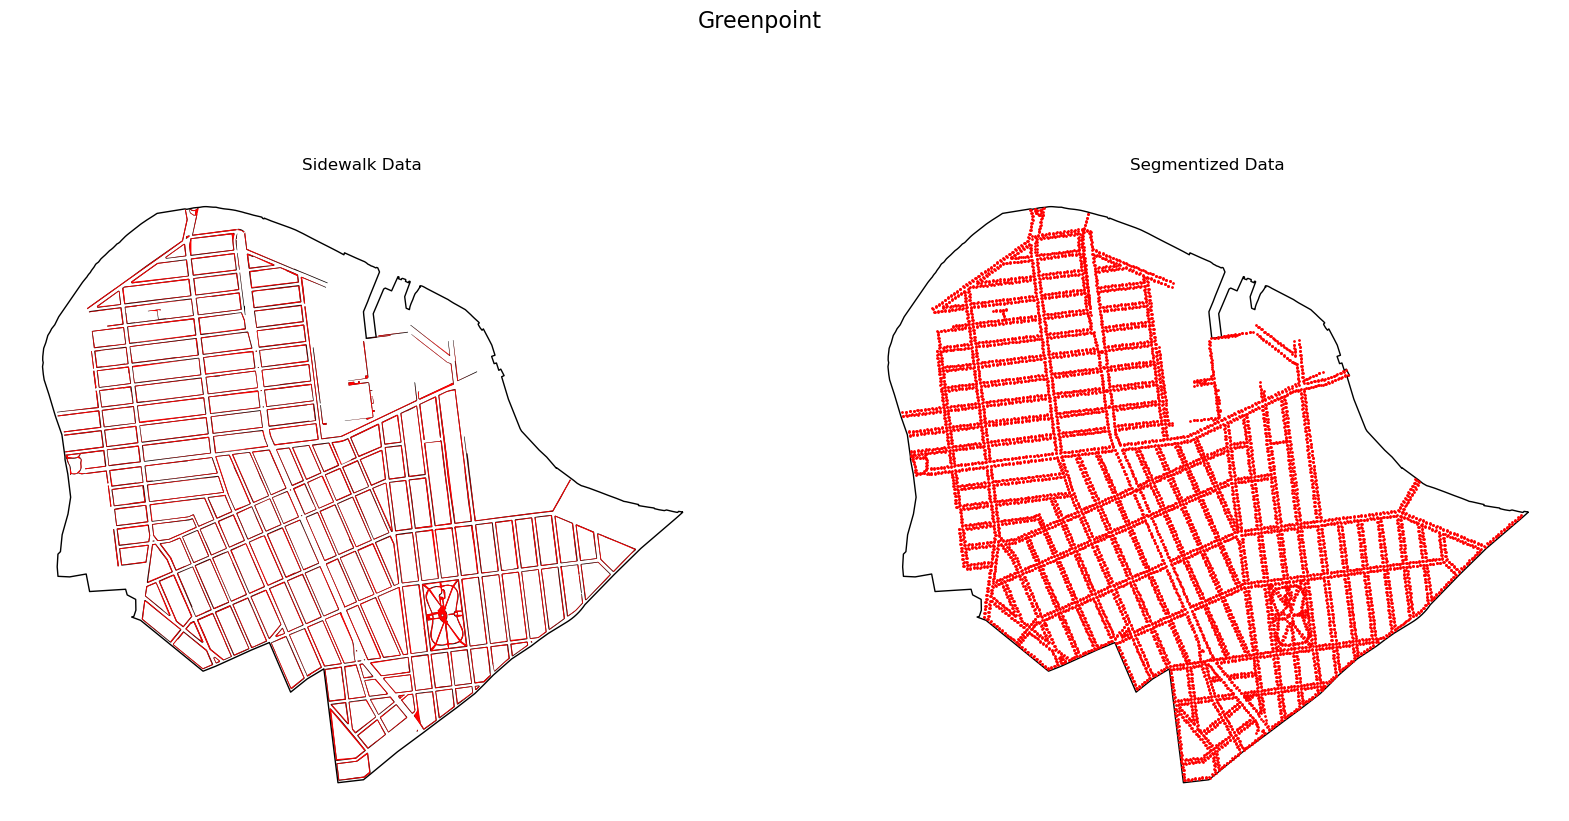

In [16]:
# side by side plot 
fig, ax = plt.subplots(1,2,figsize=(20,10))

nta_crop.plot(ax=ax[0], color='white', edgecolor='black')
nyc_streets_crop.plot(ax=ax[0], color='black', linewidth=0.5)
nyc_streets_crop_simplified.plot(ax=ax[0], color='red', linewidth=0.5)

nta_crop.plot(ax=ax[1], color='white', edgecolor='black')
segmentized_crop.plot(ax=ax[1], color='red', markersize=1)

for a in ax:
    a.set_axis_off()

# label 
ax[0].set_title('Sidewalk Data')
ax[1].set_title('Segmentized Data')

# superior title 
fig.suptitle(NOI, fontsize=16)


plt.savefig('../figures/sidewalk_segmentization.png', bbox_inches='tight', dpi=300)

In [17]:
segmentized.to_csv("../data/segmentized_nyc_sidewalks.csv")